📝 Project Title: Driver Fatigue Analysis from In-Cabin Camera
🧠 Project Overview:
This project aims to detect and analyze signs of driver fatigue using visual input from a camera placed inside the vehicle cabin. By processing real-time facial expressions and head movements, the system will be able to identify critical fatigue-related behaviors such as:

Prolonged eye closure

Frequent yawning

Drooping head

Inattentiveness or microsleep episodes

The goal is to develop a real-time monitoring system that can alert the driver when signs of drowsiness or fatigue are detected, reducing the risk of road accidents caused by reduced attention or falling asleep while driving.

🔍 What the System Will Do:
Capture real-time video from a camera installed inside the vehicle (focused on the driver’s face and head).

Detect the driver’s face and eyes using computer vision techniques (e.g., YOLO, OpenCV, or MediaPipe).

Analyze key fatigue indicators, such as:

Eye aspect ratio (EAR) for eye closure detection

Frequency and duration of blinks

Yawning detection using mouth landmarks

Head tilt and posture changes

Classify driver state into "Alert", "Drowsy", or "Fatigued".

Trigger visual or audio alerts if signs of fatigue are consistently detected (e.g., buzzer, dashboard warning).

Optionally, log fatigue events for later analysis or training improvement.

🛠️ Technologies & Tools:
Python, OpenCV, PyTorch or TensorFlow

YOLOv8 for object detection (face, eyes, mouth)

Drowsiness datasets from Kaggle (e.g., DDD, FL3D)

Real-time video processing

Optional: Embedded deployment (e.g., Jetson Nano, Raspberry Pi)

🎯 Use Cases:
Automotive safety systems

Fleet vehicle monitoring

In-cabin AI for smart/automated vehicles

Research in human behavior & fatigue prediction



Ανάλυση κόπωσης οδηγού από κάμερα μέσα στο όχημα 


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter

2025-07-29 23:57:58.503732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753833478.728482      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753833478.793724      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install split-folders

In [3]:
import splitfolders
data_dir = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)'
output_dir = '/kaggle/working/splitted_Data'
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

Copying files: 41793 files [06:33, 106.23 files/s]


In [4]:
train_dir = "/kaggle/working/splitted_Data/train"
test_dir = "/kaggle/working/splitted_Data/test"
val_dir = "/kaggle/working/splitted_Data/val"
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)

val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


Pixels of the first image after Normalization: 

[[[0.6901961  0.6745098  0.6431373 ]
  [0.6862745  0.6784314  0.6431373 ]
  [0.6862745  0.6784314  0.6431373 ]
  ...
  [0.6627451  0.654902   0.61960787]
  [0.6666667  0.65882355 0.6313726 ]
  [0.67058825 0.6627451  0.6431373 ]]

 [[0.6901961  0.6745098  0.6431373 ]
  [0.6901961  0.68235296 0.64705884]
  [0.68235296 0.68235296 0.6431373 ]
  ...
  [0.6666667  0.654902   0.61960787]
  [0.68235296 0.67058825 0.6392157 ]
  [0.6666667  0.6627451  0.6392157 ]]

 [[0.6862745  0.6627451  0.64705884]
  [0.67058825 0.6666667  0.6431373 ]
  [0.67058825 0.6745098  0.64705884]
  ...
  [0.6627451  0.654902   0.6156863 ]
  [0.67058825 0.65882355 0.627451  ]
  [0.67058825 0.654902   0.6313726 ]]

 ...

 [[0.53333336 0.4901961  0.43529415]
  [0.54509807 0.5058824  0.47058827]
  [0.5529412  0.5137255  0.4901961 ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [0.41960788 0.42352945 0.40784317]]

 [[0.52156866 0.4784314  

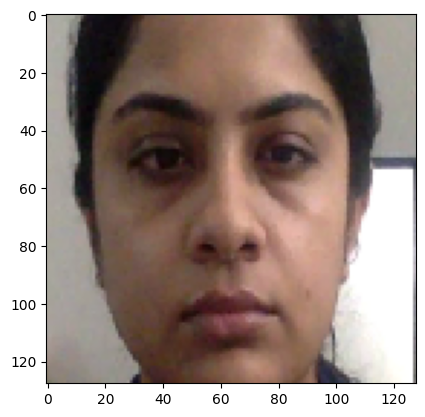

In [6]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[3]}")
plt.imshow(images[3])
plt.show()

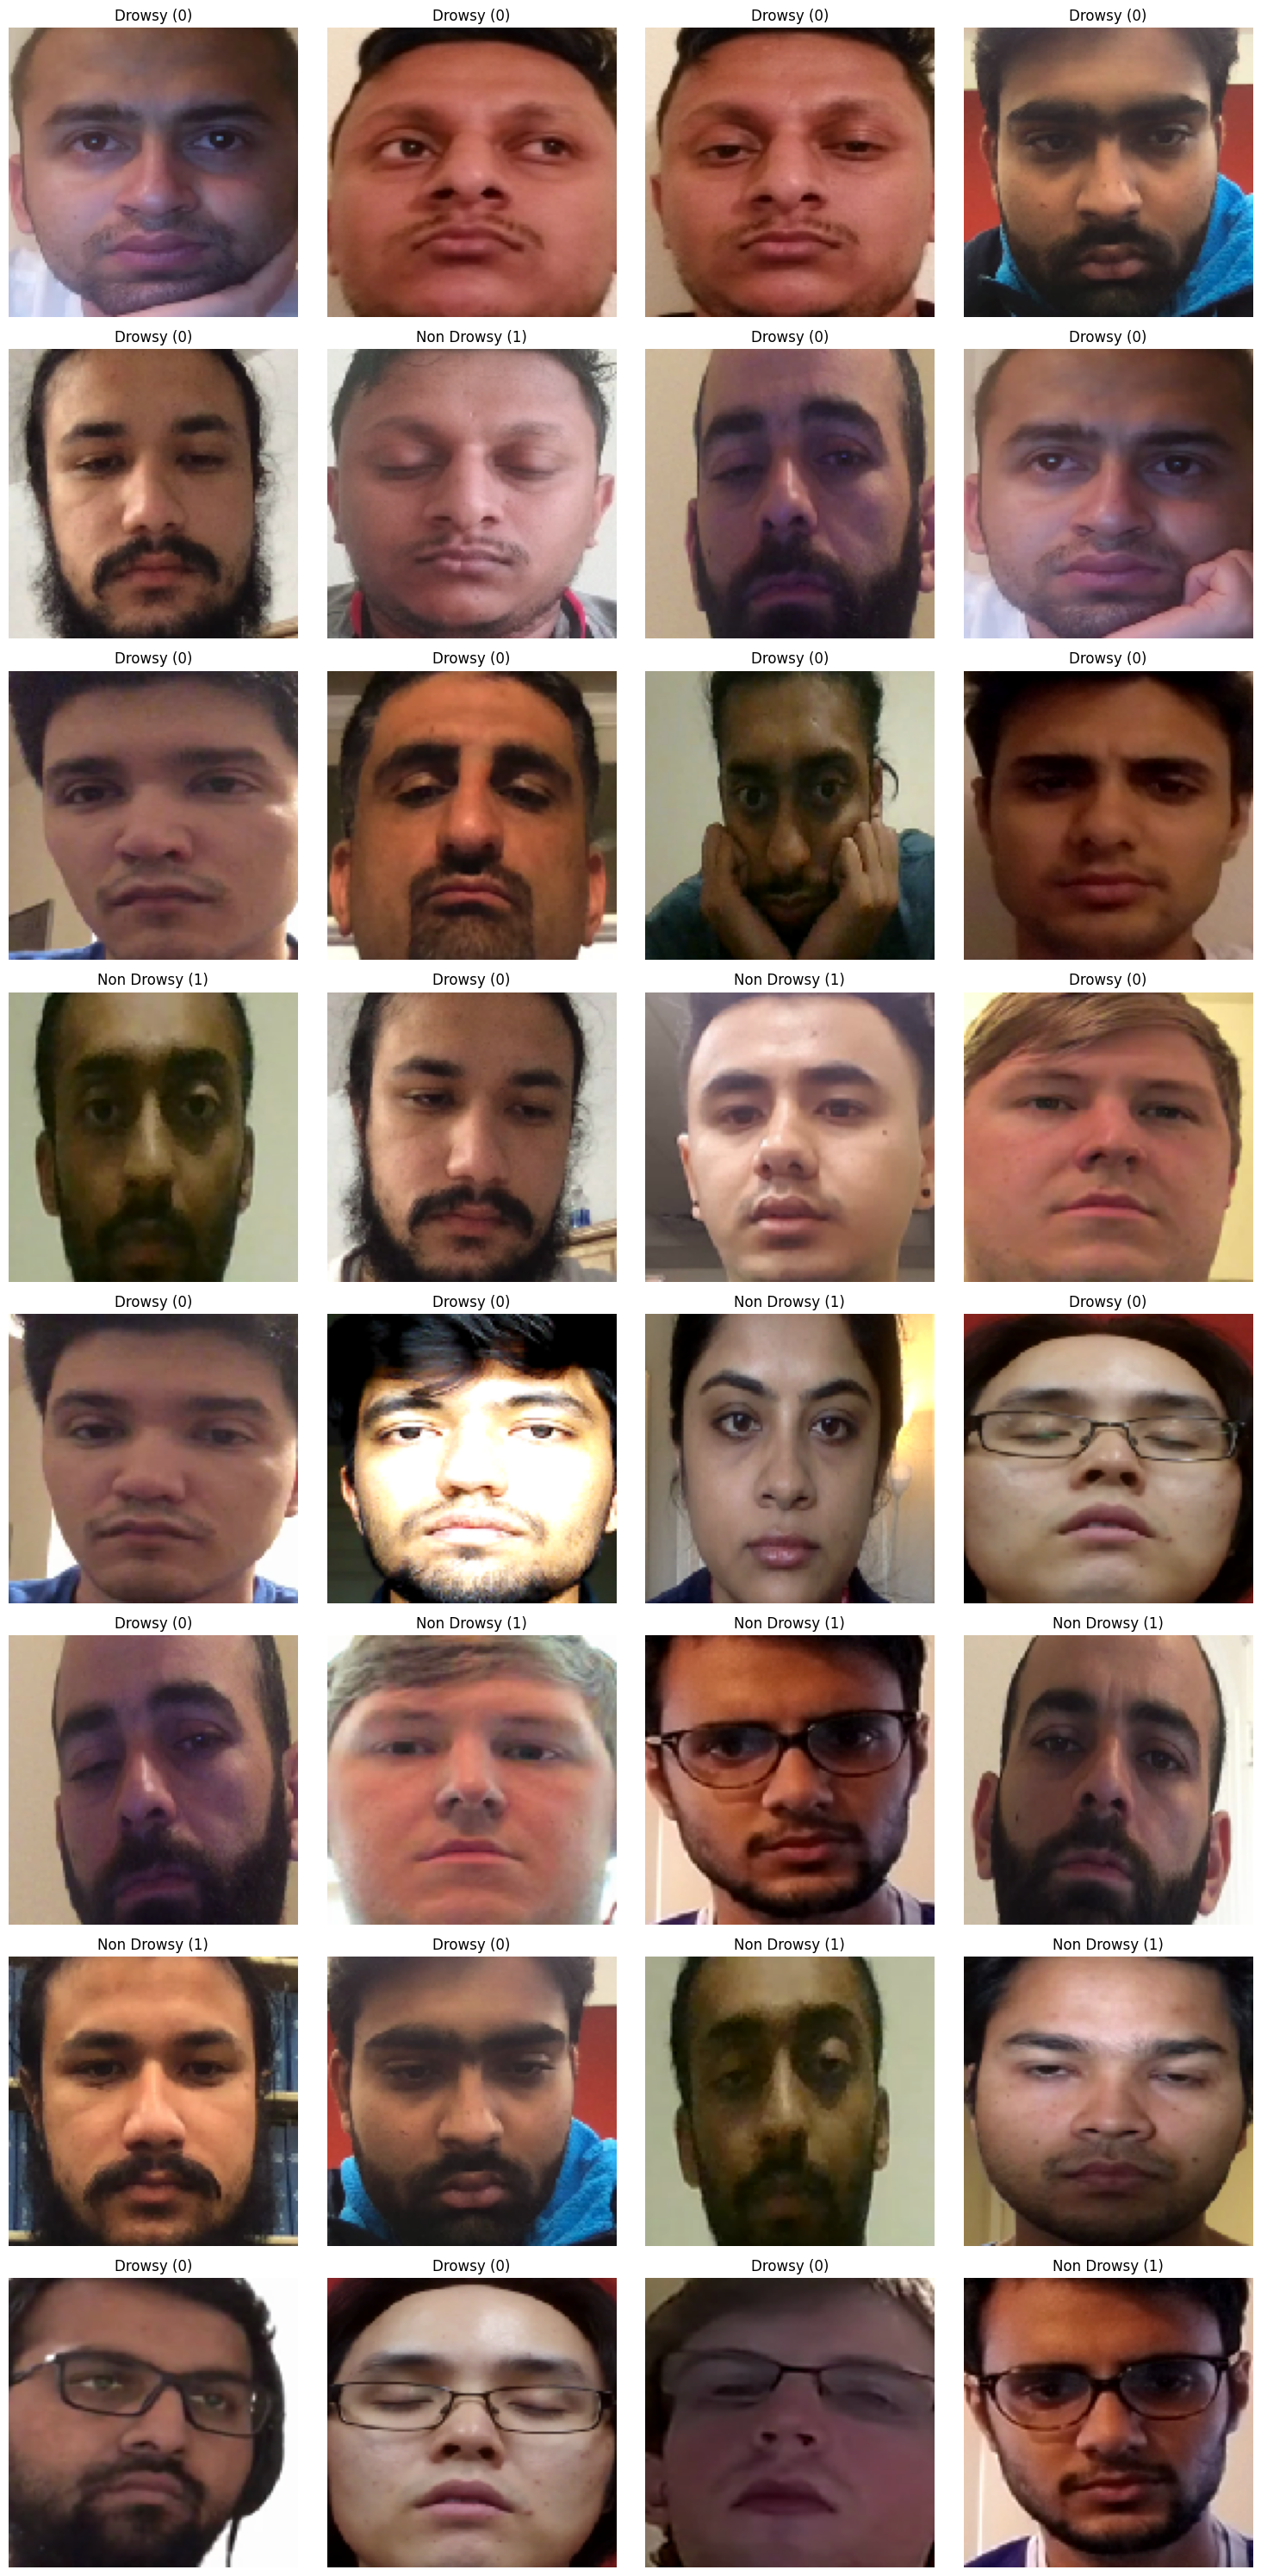

In [7]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):
        
        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])  
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

In [8]:
image_size = (128, 128)
sequence_length = 5

model = Sequential([
    TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'), input_shape=(sequence_length, image_size[0], image_size[1], 3)),
    TimeDistributed(BatchNormalization()),  
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(GlobalAveragePooling2D()),  
    LSTM(16, return_sequences=False),  
    Dropout(0.3),

    Dense(8, activation='relu'),  
    Dropout(0.3),
    Dense(1, activation='sigmoid')  
])  

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-07-30 00:05:00.421789: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 128, 128, 8) │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 128, 128, 8) │            32 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 64, 64, 8)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 5, 64, 64, 16)  │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 64, 64, 16)  │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 5, 32, 32, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 5, 32, 32, 32)  │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 5, 32, 32, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 5, 16, 16, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 5, 32)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,537 (37.25 KB)

 Trainable params: 9,425 (36.82 KB)

 Non-trainable params: 112 (448.00 B)

In [9]:
class DataGenerator(Sequence):
    def __init__(self, generator, sequence_length, batch_size):
        self.generator = generator
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator) // self.batch_size

    def __getitem__(self, index):
        X_seq, y_seq = [], []
        images, labels = [], []
        
        for _ in range(self.batch_size):
            batch_images, batch_labels = next(self.generator)
            for img, label in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(label)
                if len(images) == self.sequence_length:
                    X_seq.append(np.array(images))
                    y_seq.append(labels[-1])
                    images.pop(0)
        
        return np.array(X_seq), np.array(y_seq)

In [10]:
train_seq = DataGenerator(train_batches, sequence_length=5, batch_size=64)
val_seq = DataGenerator(val_batches, sequence_length=5, batch_size=64)


In [11]:
!pip install torchsummary

In [12]:
import os
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
from torchvision.transforms import transforms
from torchvision import  transforms, models
from torchsummary import summary
from PIL import Image 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [13]:
main_path = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/'

drowsy_paths = [os.path.join(main_path, 'Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Drowsy'))]
non_drowsy_paths = [os.path.join(main_path, 'Non Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Non Drowsy'))]

all_dirs = drowsy_paths +  non_drowsy_paths

random.shuffle(all_dirs)

total_size = len(all_dirs)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size  

# Split the data
train_paths = all_dirs[:train_size]
val_paths = all_dirs[train_size:train_size + val_size]
test_paths = all_dirs[train_size + val_size:]

random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

len_all_dirs = len(all_dirs)
len_train_paths = len(train_paths)
len_val_paths = len(val_paths)
len_test_paths = len(test_paths)

print(f"Total images: {len_all_dirs}")
print(f"Training set: {len_train_paths} images")
print(f"Validation set: {len_val_paths} images")
print(f"Test set: {len_test_paths} images")

Total images: 41793
Training set: 29255 images
Validation set: 8358 images
Test set: 4180 images


In [14]:
class MyDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = extract_class_name(img_path)

        if self.transform:
            image = self.transform(image)
        
        label = 0 if label == 'Drowsy' else 1

        return image, label
# Define data augmentation and transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),  
#     transforms.RandomRotation(10), 
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# Define transformations for validation (no augmentation)
test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
])
train_dataset = MyDataset(train_paths, transform=train_transform)
val_dataset = MyDataset(val_paths, transform=test_val_transform)
test_dataset = MyDataset(test_paths, transform=test_val_transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
import torch
from torch import nn
from torchvision import models
from torchsummary import summary

# Check if a GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the ResNet50 model
model = models.resnet50(pretrained=True)

# Move the model to the specified device
model = model.to(device)

# Summarize the model
summary(model, (3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [16]:
model = models.resnet50(weights='IMAGENET1K_V2')

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last `n` layers

n = 3
child_counter = 0
for child in model.children():
    child_counter += 1
    if child_counter > len(list(model.children())) - n:
        for param in child.parameters():
            param.requires_grad = True



num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

model = model.to(device)
summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs, total_step):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (i+1) % 100 == 0 or (i+1) == len(train_loader):
            print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss / (i+1)))
    
    avg_loss = running_loss / total_step
    return avg_loss

In [18]:
def evaluate_model(model, data_loader, criterion, device, dataset_type='Validation'):
    model.eval() 
    with torch.no_grad():
        correct = 0
        total = len(data_loader.dataset)
        total_loss = 0 
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels) 
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        
        avg_loss = total_loss / len(data_loader)
        accuracy = 100 * correct / total
        print(f'{dataset_type} Accuracy: {accuracy:.2f}% | {dataset_type} Loss: {avg_loss:.4f}')
        return avg_loss, accuracy 

In [19]:
def checkpoint_and_early_stopping(avg_val_loss, model, best_val_loss, patience, counter, path='best_model.pth'):
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), path)
        print(f"New best model saved with validation loss: {avg_val_loss:.4f}")

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            return True, best_val_loss, counter

    return False, best_val_loss, counter

In [20]:
def load_best_model(model, path='best_model.pth'):
    model.load_state_dict(torch.load(path))
    print("Best model loaded from", path)

In [21]:
num_epochs = 10
patience = 3
best_val_loss = float('inf')
counter = 0
learning_rate= 0.0001
train_losses = []
val_losses = []

In [22]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# Train the model
total_step = len(train_loader)

In [23]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        
        # Extract class label using the defined function
        label = extract_class_name(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        return len(self.image_paths)


In [24]:
import os

def extract_class_name(img_path):
    # Αν το όνομα της κατηγορίας είναι το όνομα του φακέλου της εικόνας:
    class_name = os.path.basename(os.path.dirname(img_path))  # Αν οι εικόνες είναι σε φακέλους με το όνομα της κατηγορίας
    return class_name


In [25]:
for epoch in range(num_epochs):
    avg_train_loss = train_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs, total_step)
    train_losses.append(avg_train_loss)

    avg_val_loss, _ = evaluate_model(model, val_loader, criterion, device)
    val_losses.append(avg_val_loss)

    early_stop, best_val_loss, counter = checkpoint_and_early_stopping(avg_val_loss, model, best_val_loss, patience, counter)
    
    if early_stop:
        print("Early stopping triggered.")
        break

    print('##'*20)


Epoch [1/10], Step [100/458], Train Loss: 0.2096
Epoch [1/10], Step [200/458], Train Loss: 0.1077
Epoch [1/10], Step [300/458], Train Loss: 0.0727
Epoch [1/10], Step [400/458], Train Loss: 0.0556
Epoch [1/10], Step [458/458], Train Loss: 0.0493
Validation Accuracy: 99.94% | Validation Loss: 0.0017
New best model saved with validation loss: 0.0017
########################################
Epoch [2/10], Step [100/458], Train Loss: 0.0007
Epoch [2/10], Step [200/458], Train Loss: 0.0005
Epoch [2/10], Step [300/458], Train Loss: 0.0004
Epoch [2/10], Step [400/458], Train Loss: 0.0012
Epoch [2/10], Step [458/458], Train Loss: 0.0012
Validation Accuracy: 99.96% | Validation Loss: 0.0011
New best model saved with validation loss: 0.0011
########################################
Epoch [3/10], Step [100/458], Train Loss: 0.0045
Epoch [3/10], Step [200/458], Train Loss: 0.0034
Epoch [3/10], Step [300/458], Train Loss: 0.0023
Epoch [3/10], Step [400/458], Train Loss: 0.0028
Epoch [3/10], Step [458/

In [26]:
load_best_model(model)

Best model loaded from best_model.pth


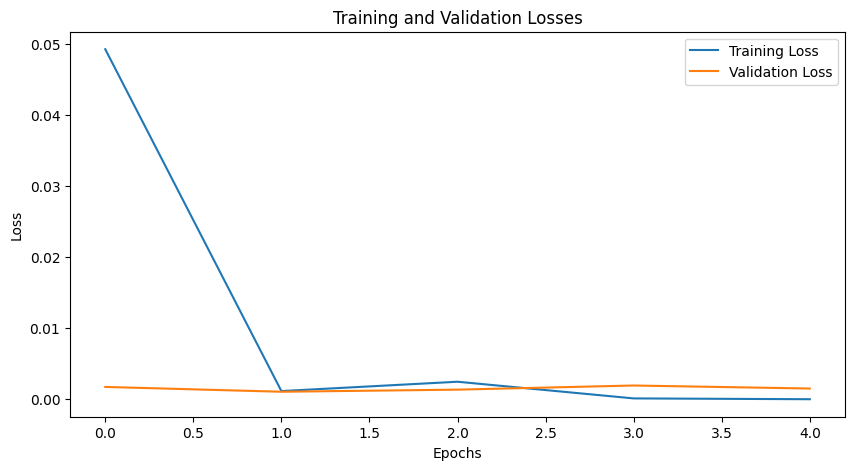

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [28]:
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device, dataset_type='Test')

Validation Accuracy: 99.96% | Validation Loss: 0.0011
Test Accuracy: 100.00% | Test Loss: 0.0001


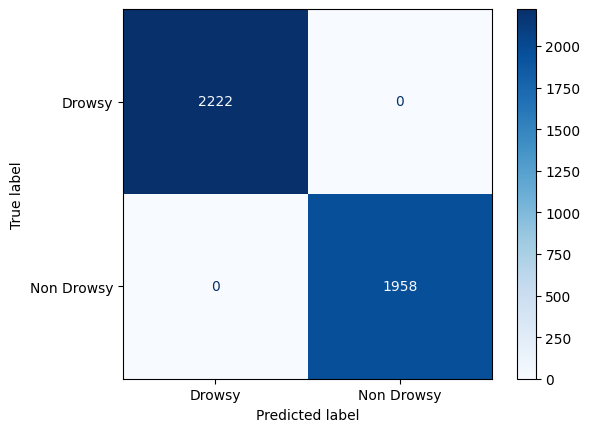

In [29]:
def evaluate_and_confusion_matrix(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Drowsy', 'Non Drowsy'])
    
    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
evaluate_and_confusion_matrix(model, test_loader, criterion, device)